# 一个volume策略的想法
## volume 处理
绘制出10日和30日volume的ROC，如果30日减去10日的ROC=roc_d,
累加特定周期的roc_d=acc_roc_d,绘制曲线，曲线出现跳高或者跳低说明有趋势行情
## 其他
其他信号（比如均线信号，MACD信号）叠加acc_roc_d显示出的趋势
是否可以成为较好的买卖信号？

下面是对你笔记里策略想法的简短说明与要点（中文）。

这个策略核心是用交易量的变动率（ROC，Rate of Change）去捕捉趋势信号：分别计算10日和30日的成交量ROC，令两者之差为单日差异 roc_d，再对若干周期累加这些差异得到 acc_roc_d 并绘图，若曲线出现明显跳升/跳降就被认为对应有趋势性的行情。

关于计算，常用的ROC定义为
$ROC_n(t)=\dfrac{V_t-V_{t-n}}{V_{t-n}}$，
这里 $V_t$ 是第 t 日的成交量。然后
$roc\_d_t = ROC_{30}(t) - ROC_{10}(t)$，
累加可以用滑动窗口或累计和：
$$acc\_roc\_d_t=\sum_{i=t-m+1}^{t} roc\_d_i$$
（m 是你选择的累加周期）。

信号含义：当 $roc\_d$ 或 $acc\_roc\_d$ 快速上升，说明长期量能相对短期放大，可能伴随价格上行趋势；快速下降则可能预示下行或流动性萎缩。把这个量能趋势与均线、MACD 等价格动量指标叠加，可以过滤虚假波动、提高信噪比——比如只有在价格突破且 acc_roc_d 为正时才开多仓。

注意事项与陷阱：ROC 对极端的单日成交量峰值很敏感，需考虑去极值或使用对数/百分位归一化；累加周期 m 的选择会影响信号延迟与噪声；须避免未来函数/回测中的数据泄露；成交量在不同品种或不同时间段基准差异大，最好做相对化或按分位数标准化。最后强烈建议用步进回测和稳健性检验（不同股期、不同子区间）来选择阈值与周期，并加上明确的止损/仓位管理。

In [13]:
import pandas as pd
from cal_roc import CalRoc
from cal_roc_acc import CalRocAcc
from data_collect_akshare import collectfrom_aksh
import mplfinance as mpf

# 下面开始实现策略
# 使用新的CalRocAcc类来计算累计ROC指标

stock_data = collectfrom_aksh('sh688981', '20250220', '20251219')
stock_calrocacc = CalRocAcc(stock_data, periodA=30, periodB=10, roll_period=15)
stock_roc_acc = stock_calrocacc.get_roc_data()

# 仅用于测试不同滚动周期的效果
stock_calrocacc1 = CalRocAcc(stock_data, periodA=30, periodB=10, roll_period=10)
stock_roc_acc1 = stock_calrocacc1.get_roc_data()

print(stock_roc_acc.head(5))
print(stock_roc_acc.tail(5))
print(stock_roc_acc.columns)
print(f"DataFrame 的总行数: {len(stock_roc_acc)}")
print(f"DataFrame 的形状 (行数, 列数): {stock_roc_acc.shape}")

            open_rocA_30  high_rocA_30  low_rocA_30  close_rocA_30  \
date                                                                 
2025-04-24     -0.065803     -0.070582    -0.075332      -0.070907   
2025-04-25     -0.065940     -0.067964    -0.044191      -0.049043   
2025-04-28     -0.049043     -0.068194    -0.048649      -0.069402   
2025-04-29     -0.072400     -0.067327    -0.057535      -0.057513   
2025-04-30     -0.061283     -0.066701    -0.062726      -0.053666   

            volume_rocA_30  open_rocB_10  high_rocB_10  low_rocB_10  \
date                                                                  
2025-04-24       -0.270873     -0.020322     -0.021480    -0.014696   
2025-04-25       -0.479497     -0.019370     -0.062107    -0.024058   
2025-04-28       -0.640072     -0.054332     -0.047573    -0.040244   
2025-04-29       -0.579850     -0.041176     -0.035730    -0.020963   
2025-04-30       -0.324227     -0.030440     -0.028152    -0.020697   

           

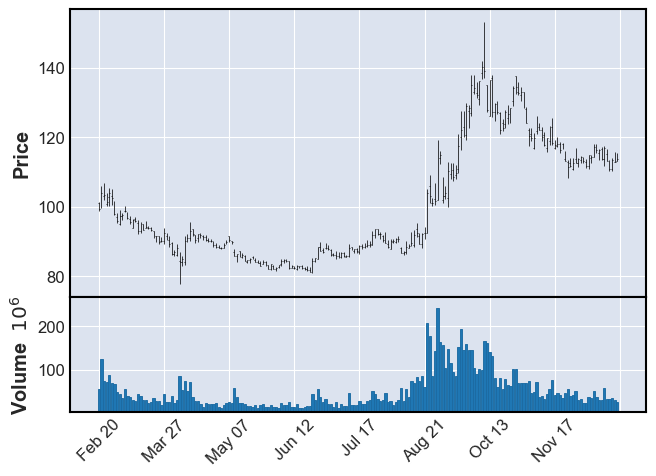

In [14]:
mpf.plot(stock_data, volume=True)

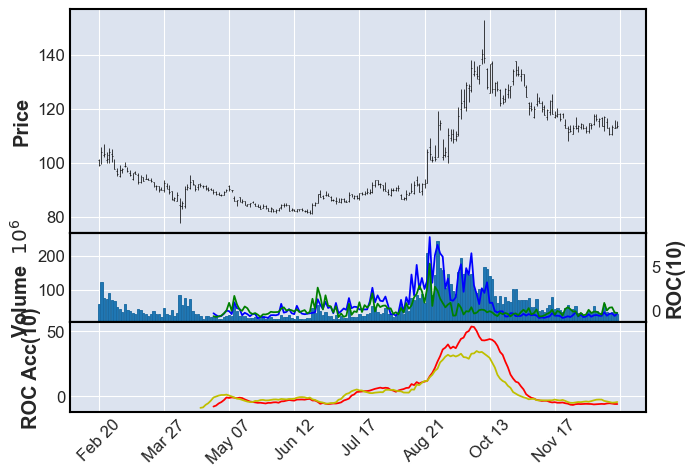

In [15]:
stock_data['volume_rocA_30'] = stock_roc_acc['volume_rocA_30']
stock_data['volume_rocB_10'] = stock_roc_acc['volume_rocB_10']
stock_data['volume_acc_roc_diff_30_10_15'] = stock_roc_acc['volume_acc_roc_diff_30_10_15']
stock_data['volume_acc_roc_diff_30_10_10'] = stock_roc_acc1['volume_acc_roc_diff_30_10_10']


apds = [
    mpf.make_addplot(stock_data['volume_rocA_30'], panel=1, color='b', ylabel='ROC(30)'),
    mpf.make_addplot(stock_data['volume_rocB_10'], panel=1, color='g', ylabel='ROC(10)'),
    mpf.make_addplot(stock_data['volume_acc_roc_diff_30_10_15'], panel=2, color='r', ylabel='ROC Acc(15)'),
    mpf.make_addplot(stock_data['volume_acc_roc_diff_30_10_10'], panel=2, color='y', ylabel='ROC Acc(10)')
]

mpf.plot(stock_data, volume=True, addplot=apds)